In [1]:
%matplotlib inline
from functools import reduce
import pandas as pd
import os, fnmatch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib as mpl
import pickle as pkl
import scipy
import statsmodels.api as sm

In [2]:
def readDat(files, path, time_zone, from_wrf = True):
    """
    Read time series csv files for each station code from a specific path
    
    Parameters
    ----------
    files : str list
        name of csv files
    path  : str
        path location
    time_zone : str
        for instance 'America/Sao_Paulo'
    
    Returns
    -------
    Pandas DataFrame
    """
    Data = pd.DataFrame()
    
    if from_wrf:
        for file in files:
            df = pd.read_csv(path + file)
            Data = pd.concat([Data,df])
        Data = Data[Data.code.isin(stations.code)]
        Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
        Data['type'] = [stations[stations.code == i].type.values[0] for i in Data.code]
        Data.loc[:,'date'] = pd.to_datetime(Data['date'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize("UTC")
        Data.loc[:,'local_date']=Data['date'].dt.tz_convert(time_zone)
        return Data
    
    else: # observations
        for file in files:
            df = pd.read_csv(path + file)
            Data = pd.concat([Data,df])
        Data = Data[Data.code.isin(stations.code)]
        Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
        Data['type'] = [stations[stations.code == i].type.values[0] for i in Data.code]
        Data.loc[:,'date'] = pd.to_datetime(Data['date'], format='%Y-%m-%d %H:%M:%S')
        Data.rename(columns={'date':'local_date'}, inplace = True)
        Data.loc[:,'local_date']=Data['local_date'].dt.tz_localize(time_zone)
        return Data

def subplots(df,pol,ylabel,xlabel,suffixes,legend, size, n_yticks, n_xticks,filename,alpha,lw,markersize,labelsize, by):
    """
    Return lineplot subplots by station only completed data to be compared.
    
    Parameters
    ----------
    df       : pandas DataFrame with datetime as index
               time series with colnames as station and meteorological and air quality parameters
    pol      : str
               air quality parameter, for instance, pol = 'o3'
    ylabel   : str
    xlabel   : str
    suffixes : list of two strings, for instance suffixes = ['_obs','_mod']
    legend   : list of two strings
    size     : tuple, default size = (6,8)
    n_yticks : int
               Number of yaxis labels
    n_xticks : int
               Interval number of xaxis labels               
    path     : str
               path location where the figure will be located
    name     : str
               suffix name of figure
    alpha    : float between 0 and 1. Default 0.7
    lw       : int
    markersize : int
    labelsize : int
    by       : str
               subplots by specific name based column names
    
    Returns
    -------
    Figure exported as pdf plot in a specific path
    
    """
    df_1 = df[['station','type',pol+suffixes[0],pol+suffixes[1]]].dropna()
    locs = list(df_1.sort_values(by=by,ascending=True)[by].unique())
    
    fig, ax = plt.subplots(df_1[by].nunique(),
                           figsize=size, 
                           sharex=True, sharey=True,
                           gridspec_kw={'hspace':0.4})
    for i in range(df_1[by].nunique()):
        df_1.loc[df_1[by] == locs[i]][pol+suffixes[0]].\
        plot(ax=ax[i],color='k', marker='.',linestyle='none',
             markersize=markersize, label=legend[0])
        df_1.loc[df_1[by] == locs[i]][pol+suffixes[1]].\
        plot(ax=ax[i],color='g', marker='o',markersize=markersize,markeredgecolor='none',linestyle='none',lw=lw, alpha=alpha, label=legend[1])
        if pol and by == ('co' and 'type'):
            ax[i].set_ylabel(ylabel)
        else:
            ax[2].set_ylabel(ylabel)
        ax[0].xaxis.set_major_formatter(md.DateFormatter('%a-%d'))
        ax[0].xaxis.set_major_locator(md.DayLocator(np.arange(0,31,n_xticks)))
        ax[0].xaxis.set_minor_locator(md.MonthLocator())
        ax[0].xaxis.set_minor_formatter(md.DateFormatter('\n\n\n%b-%y'))
        ax[i].yaxis.set_major_locator(plt.MaxNLocator(n_yticks))
        ax[i].tick_params(axis='both', which='minor', labelsize=labelsize)
        ax[i].tick_params(axis='both', labelsize=labelsize)
        ax[i].set_xlabel(xlabel)
        ax[i].set_title(locs[i],size=8, loc='left')
        if i == len(df_1[by].unique())-1:
            ax[i].legend(fontsize=7)
    fig.savefig(filename+'_subplot_'+pol+'.pdf',bbox_inches='tight', facecolor='w')



# Evaluation of Simulation Results for September 2018
Two types of measured data are air quality and meteorological parameters from CETESB stations. Only IAG station belongs to São Paulo University, located in Água Funda, and measures meteorological parameters. The evaluation period corresponds to September 1-30, 2018. Measured data has time series in hourly resolution.

Some stations located close to coastal zone were not included as part of statistical evaluation, which are:

* Santos
* Santos-Ponta da Praia
* Cubatão-Centro
* Cubatão-Vale do Mogi
* Cubatão-V.Parisi

Furthermore, hourly measurements for September 14-15, 2018 were not considered to statistical analysis due to cloud and rainfall conditions that WRF-Chem couldn't simulate adequately. Following Figure shows mean cloud cover and total rain by day, gray highlight represents days excluded in the statistical evaluation.

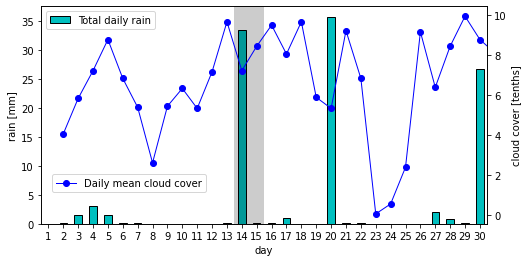

In [64]:
met_iag = pd.read_csv('../2_Met/IAG/all_met_0.csv', 
                      parse_dates=True, 
                      index_col='local_date').loc[:'2018-09-30 23',:]

met_iag['day'] = met_iag.index.day
met_iag = met_iag[['day','rr','cc']].groupby('day').agg({'rr':'sum','cc':'mean'})
fig, ax = plt.subplots(figsize=(8,4))
plot_rr = met_iag.rr.plot(kind='bar', rot=0, color='c', edgecolor='k', label='Total daily rain', legend=True)
ax.legend(loc=2)
ax2 = ax.twinx()
met_iag.cc.plot(rot=0,ax=ax2, lw=1, color='b',marker='o',label='Daily mean cloud cover', legend=True)
ax2.legend(bbox_to_anchor=(0.38, 0.25))
ax.set_ylabel('rain [mm]')
ax2.set_ylabel('cloud cover [tenths]')
def highlight(indices,ax):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor='0', edgecolor='none', alpha=.2)
        i+=1
highlight([13,14], plot_rr)
fig.savefig('../4_Draft_Report/Dissertation/fig/rain_cc.pdf', bbox_inches='tight')

In [4]:
stations = pd.read_csv('../1_ObsData/stations.csv')
not_stations = ['Santos',
                'Santos-Ponta da Praia',
                'Cubatão-Centro',
                'Cubatão-Vale do Mogi',
                'Cubatão-V.Parisi']
stations = stations.loc[(~stations.name.isin(not_stations)) & \
                        (stations.domain =='d02')]\
            .drop('domain', axis=1).sort_values(by='code')
stations.index =stations.code
stations.head()

,name,lat,lon,code,type,abb
code,,,,,,
0,IAG,-23.651200,-46.622400,0,Forest preservation,IAG
63,Santana,-23.505993,-46.628960,63,Urban,Stna
64,Santo Amaro,-23.654977,-46.709998,64,Urban,SAm
65,Mauá,-23.668549,-46.466000,65,Urban,Maua
67,Sorocaba,-23.502427,-47.479030,67,Regional urban,Srcb


In [5]:
 print(f"""
 We have {stations.name.nunique()} stations with hourly measurements obtained to compared with
 WRF-Chem results. Also, there are {stations.type.nunique()} stations type, which are:
 {list(stations.type.unique())}.
 """)


We have 57 stations with hourly measurements obtained to compared with
WRF-Chem results. Also, there are 5 stations type, which are:
['Forest preservation', 'Urban', 'Regional urban', 'Urban park', 'Industry'].



## September, 2018

WRF-Chem model results for September 2018 correspond to second domain with spatial resolution of 3 km $\times$ 3 km. The results were obtained using NALROM as chemical boundary conditions and NCEP Final Analysis from GFS as meteorology initial and boundary conditions. To model all hours of September, model was reinitializated each 5 days with one day of spin-up was done, methodology suggested by Ritter (2013). We use the function `readDat` to import and merge WRF-Chem data by station name, named as `data`. O$_3$ 8 hours rolling mean was calculated and named as `rollo3`. Hourly mean by station type was also calculated and named as `by_type`.

In [6]:
# Import and join Obs and Mod data
filename = 'data/alldata_Sep18_not14_15.pkl' # as pandas DataFrame
fname_1 = 'data/Obs_dic_not14_15.pickle'     # as Dictionary
fname_2 = 'data/Mod_dic_not14_15.pickle'     # as Dictionary
#filename = 'alldata_Sep18.pkl'
#fname_1 = 'Obs_dic.pickle'
#fname_2 = 'Mod_dic.pickle'

if os.path.exists(filename) is False:
    # Meteorological parameters observations
    Dir = '../1_ObsData/SEP18/'
    f18 = fnmatch.filter(os.listdir(Dir), 'all_met*.csv')
    metObs = readDat(f18, path = Dir, time_zone='America/Sao_Paulo',from_wrf = False)

    # Air quality parameters observations
    f18 = fnmatch.filter(os.listdir(Dir), 'all_photo*.csv')
    aqObs = readDat(f18, path = Dir, time_zone='America/Sao_Paulo', from_wrf = False)
    Obs = pd.merge(metObs, aqObs)
    Obs['nox']=Obs.no+Obs.no2
    #start_remove = pd.to_datetime('2018-09-14').tz_localize('America/Sao_Paulo')
    #end_remove = pd.to_datetime('2018-09-16').tz_localize('America/Sao_Paulo')
    #Obs = Obs.loc[(Obs.local_date < start_remove) | (Obs.local_date > end_remove)]
    # As dictionary
    Obs_dic = {}
    for code in stations.code:
        Obs_dic[stations.name[stations.code == code].values[0]] = (Obs[Obs.code==code])

    # WRF-Chem output re-initialization with one day of spin-up
    Dir = '../3_Results/Y2018/wrfout_exp10/sep18/'
    f18 = fnmatch.filter(os.listdir(Dir), '*FIN_d02*')

    Mod = readDat(f18, path = Dir,time_zone='America/Sao_Paulo', from_wrf=True)
    Mod.rename(columns={'name':'station'})
    Mod = Mod[['local_date','code','station','type','tc','rh','ws','wd','o3','no','no2','co']]
    Mod['nox'] = Mod.no+Mod.no2
      # As dictionary
    Mod_dic = {}
    for code in stations.code:
        Mod_dic[stations.name[stations.code == code].values[0]] = (Mod[Mod.code==code])

    data = pd.merge(Obs, Mod,
                    on=['local_date','station','code','type'],
                    suffixes=('_obs', '_mod'))
    # to pickle
    data.to_pickle(filename)
    pkl.dump(Obs_dic, open(fname_1, "wb"))
    pkl.dump(Mod_dic, open(fname_2, "wb"))

else:
    data = pd.read_pickle(filename)
    Obs_dic = pkl.load(open(fname_1, "rb"))
    Mod_dic = pkl.load(open(fname_2, "rb"))

# Rolling 8 hour mean
o3 = data[['local_date','station','type', 'o3_obs','o3_mod']].set_index('local_date')
roll_o3 = {}
rollo3 = pd.DataFrame()
for i in o3.station.unique():
    roll_o3[i] = (o3[o3.station == i].rolling(window=8).mean()[['o3_obs','o3_mod']])
    roll_o3[i]['station'] = (i)
    roll_o3[i]['type'] = (o3[o3.station == i].type)
    df = roll_o3[i]
    rollo3 = pd.concat([rollo3,df])
    rollo3['day'] = rollo3.index.day
    MDA8 = rollo3.groupby(['day','station','type']).max().reset_index().dropna()

# Hourly mean by station type
by_type = data.groupby(['local_date','type']).mean().reset_index().drop(['code'], axis=1)

### Statistical Evaluation
The `Mod_statistic` script was built by Mario Gavidia and with few changes done by me. Here you see the follow functions:
```python
* aq_Stats(data, polls=['o3', 'no', 'no2', 'co', 'tc', 'rh'])
* met_stats(data,mets=['tc','rh','ws','wd'])
* r_pearson_sig(n, r, alpha, deg_free = 2)
* r_pearson_confidence_interval(n, r, alpha)
```

Statistical benchmarks from Emery et al. (2017) were used to evaluate surface ozone (1 hour or mean values of the daily maximum 8 h average (MDA8) ozone) obtained from the WRF-Chem model:

Parameter |   Goal   |  Criteria  |
--------- |----------|----------- |
NMB | < $\pm$5% | < $\pm$15%
NME | < 15% | < 25%
r | > 0.75 | > 0.5

Furthermore, statistical benchmarks from Monk et al. (2019) were used to evaluate meteorology results for complex terrain:

Parameter        | Criteria (complex terrain)
----------       | --------
Temperature      | MB  $\leq\pm$ 1 K
                 | MAGE $\leq$ 3.0
                 | IOA $\geq$ 0.8
Wind speed       | RMSE $\leq$ 2.5
                 | MB   $\leq \pm$ 1.5 ms$^{-1}$
                 | IOA $\geq$ 0.6
Wind direction   | MB < $\pm$ 10º
                 | ME $\leq$ 55º
Relative Humidity| MB < $\pm$10%
                 | MAGE < 20%
                 | IOA $\geq$ 0.6

Global statistical results by hour are showed in the following table.

In [7]:
import mod_stats as ms
gl_stat = ms.aq_stats(data,
             polls=['o3', 'no', 'no2', 'nox','co']).round(2)
gl_stat.T.to_pickle('data/gl_stat_sep18.pkl')
gl_stat.T

,o3,no,no2,nox,co
n,23849.00,21631.00,21631.00,21631.00,9805.00
MB,9.35,-0.61,4.03,3.42,-0.26
MAGE,24.01,10.47,18.29,27.67,0.29
RMSE,30.08,23.74,25.74,43.55,0.40
NMB,19.28,-7.22,15.36,9.87,-52.30
NME,49.52,124.15,69.66,79.79,59.31
IOA,0.80,0.46,0.62,0.58,0.45
r,0.67,0.25,0.39,0.34,0.19
Mm,57.83,7.82,30.28,38.11,0.23
Om,48.48,8.43,26.25,34.68,0.49


In [8]:
by = 'type'
sites = list(data[[by,'o3_obs','o3_mod']].dropna().sort_values(by=by,ascending=True)[by].unique())
o3_stats = {}
o3sta_df = pd.DataFrame()
for i in sites:
    o3_stats[i] = (ms.aq_stats(data[data[by].isin([i])],polls=['o3']))
    o3_stats[i][by] = (i)
    df = o3_stats[i]
    o3sta_df = pd.concat([o3sta_df,df]).round(2)
o3sta_df = o3sta_df.sort_values(by='r', ascending=False).loc['o3']
o3sta_df = o3sta_df.set_index('type').T.rename(columns={'Industry':'Ind',
                                                        'Forest preservation':'F. pre.',
                                                        'Regional urban':'R. urb.',
                                                        'Urban park': 'U. park',
                                                        'Urban':'Urb'})
o3sta_df = o3sta_df[['F. pre.','Urb','U. park','Ind','R. urb.']]
o3sta_df.to_pickle('data/o3sta_sep18.pkl')
o3sta_df

type,F. pre.,Urb,U. park,Ind,R. urb.
n,636.00,11314.00,2205.00,637.00,9057.00
MB,0.51,4.03,-1.68,17.20,18.75
MAGE,24.44,23.27,23.35,27.23,24.83
RMSE,30.64,29.54,29.25,32.52,30.70
NMB,1.02,8.96,-3.49,33.95,35.57
NME,48.90,51.75,48.54,53.75,47.11
IOA,0.81,0.80,0.82,0.85,0.76
r,0.72,0.68,0.69,0.80,0.69
Mm,50.49,49.00,46.43,67.85,71.45
Om,49.98,44.97,48.11,50.65,52.70


<AxesSubplot:ylabel='Density'>

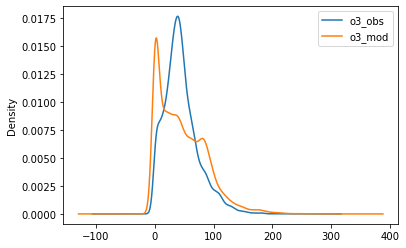

In [9]:
data[data.type =='Urban'].plot(kind='density', y=['o3_obs','o3_mod'])

In [10]:
para = ['F. pre.','Urb','U. park','Ind','R. urb.']
df_1 = pd.DataFrame(index=['t-statistic', 't critical'])

for p in para:
    df_1[p] = ms.r_pearson_sig(n=o3sta_df.loc['n',p],
                             r=o3sta_df.loc['r',p],
                             deg_free=o3sta_df.loc['n',p]-2,
                             alpha=0.05)
df_1.round(2)

Significant linear relationship
Significant linear relationship
Significant linear relationship
Significant linear relationship
Significant linear relationship


,F. pre.,Urb,U. park,Ind,R. urb.
t-statistic,26.12,98.64,44.74,33.60,90.71
t critical,1.96,1.96,1.96,1.96,1.96


In [10]:
#print(df_1.round(2).to_latex(caption='t-test values for correlation coefficient (r) for Sep. 2018',
#                            label='tab: r_sign'),
#      file=open('../4_Draft_Report/Dissertation/table/r_sign.tex','w'))

In [11]:
sites = list(data[['station','o3_obs','o3_mod']].dropna().sort_values(by='station',ascending=True).station.unique())
o3_stats = {}
o3sta_df = pd.DataFrame()
for i in sites:
    o3_stats[i] = (ms.aq_stats(data[data.station.isin([i])],polls=['o3']))
    o3_stats[i]['station'] = (i)
    df = o3_stats[i]
    o3sta_df = pd.concat([o3sta_df,df]).round(2)
o3sta_df = o3sta_df.sort_values(by='r', ascending=False).loc['o3']
o3sta_df['abb'] = [stations[stations.name == i].abb.values[0] for i in o3sta_df.station]
o3sta_df['type'] = [stations[stations.name == i].type.values[0] for i in o3sta_df.station]
o3sta_df[(o3sta_df.n > 600) & (o3sta_df.NME < 60) & (o3sta_df.NMB < 40)]

,n,MB,MAGE,RMSE,NMB,NME,IOA,r,Mm,Om,Msd,Osd,station,abb,type
o3,637,17.20,27.23,32.52,33.95,53.75,0.85,0.80,67.85,50.65,36.60,46.19,Paulínia,Pln,Industry
o3,637,9.70,19.25,24.26,15.62,30.99,0.86,0.78,71.82,62.11,29.96,35.50,Campinas-Taquaral,CpT,Regional urban
o3,636,18.61,25.75,30.34,34.08,47.16,0.82,0.78,73.22,54.61,30.92,38.49,Piracicaba,Prcb,Regional urban
o3,609,14.76,24.39,29.72,24.09,39.81,0.82,0.76,76.03,61.27,30.95,39.59,Americana,Ame,Regional urban
o3,640,14.79,24.06,29.89,29.03,47.22,0.84,0.76,65.73,50.94,37.66,37.91,Jundiaí,Jnd,Regional urban
o3,640,2.48,25.14,30.67,5.21,52.84,0.84,0.74,50.06,47.58,45.61,35.43,Carapicuíba,Crp,Urban
o3,649,2.15,23.10,29.42,5.07,54.63,0.84,0.73,44.43,42.28,43.21,32.58,Santana,Stna,Urban
o3,640,19.53,23.23,27.47,36.29,43.16,0.74,0.72,73.34,53.81,21.73,27.67,Jaú,Jau,Regional urban
o3,636,0.51,24.44,30.64,1.02,48.90,0.81,0.72,50.49,49.98,43.91,28.98,Pico do Jaraguá,PdJr,Forest preservation
o3,640,-8.55,24.18,30.26,-16.63,47.04,0.82,0.72,42.86,51.40,41.82,33.11,Ibirapuera,Ibir,Urban park


In [57]:
o3sta_df[o3sta_df.IOA > 0.8]

,n,MB,MAGE,RMSE,NMB,NME,IOA,r,Mm,Om,Msd,Osd,station,abb,type
o3,637,17.20,27.23,32.52,33.95,53.75,0.85,0.80,67.85,50.65,36.60,46.19,Paulínia,Pln,Industry
o3,637,9.70,19.25,24.26,15.62,30.99,0.86,0.78,71.82,62.11,29.96,35.50,Campinas-Taquaral,CpT,Regional urban
o3,636,18.61,25.75,30.34,34.08,47.16,0.82,0.78,73.22,54.61,30.92,38.49,Piracicaba,Prcb,Regional urban
o3,609,14.76,24.39,29.72,24.09,39.81,0.82,0.76,76.03,61.27,30.95,39.59,Americana,Ame,Regional urban
o3,640,14.79,24.06,29.89,29.03,47.22,0.84,0.76,65.73,50.94,37.66,37.91,Jundiaí,Jnd,Regional urban
o3,440,16.06,22.73,27.61,28.21,39.94,0.81,0.76,72.98,56.92,27.39,34.71,Limeira,Lmr,Regional urban
o3,640,2.48,25.14,30.67,5.21,52.84,0.84,0.74,50.06,47.58,45.61,35.43,Carapicuíba,Crp,Urban
o3,649,2.15,23.10,29.42,5.07,54.63,0.84,0.73,44.43,42.28,43.21,32.58,Santana,Stna,Urban
o3,636,0.51,24.44,30.64,1.02,48.90,0.81,0.72,50.49,49.98,43.91,28.98,Pico do Jaraguá,PdJr,Forest preservation
o3,324,3.45,22.30,27.90,8.02,51.80,0.84,0.72,46.51,43.05,38.45,35.14,Cid.Universitária-USP-Ipen,USP,Urban park


In [55]:
o3sta_df.NMB.count()

39

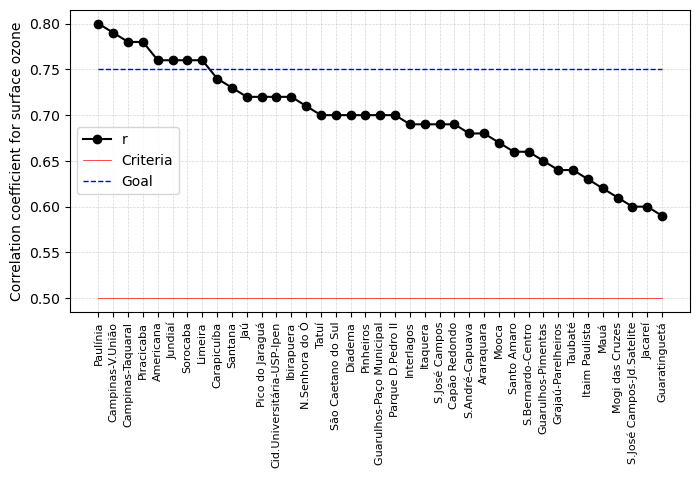

In [12]:
x = o3sta_df.station

fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(x,o3sta_df.r,'ko-', label='r')
plt.plot(x,[0.5 for i in x],'r-', label='Criteria', lw=0.5)
plt.plot(x,[0.75 for i in x],'b--', label='Goal', lw=1)
plt.xticks(x, rotation='vertical', fontsize=8)
plt.ylabel('Correlation coefficient for surface ozone')
plt.legend()
plt.grid(color='0.2', ls='--', lw=0.5,alpha=0.2)
fig.savefig('../4_Draft_Report/Dissertation/fig/o3_r_by_station.pdf',bbox_inches='tight')

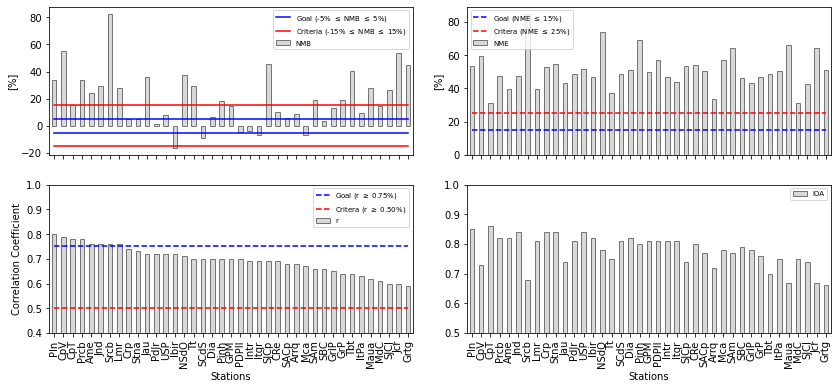

In [41]:
fig, ax = plt.subplots(2,2, figsize=(14,6),sharex=True, gridspec_kw={'wspace':0.15})
df_stat = o3sta_df

# Script
NMB = df_stat.reset_index(drop=True).set_index('abb')[['NMB']]
NMB['PG'] = 5
NMB['NG'] = -5
NMB['PC'] = 15
NMB['NC'] = -15
# ax[0,0]
NMB.NMB.plot.bar(rot=90,ax=ax[0,0], color='0.7',edgecolor='k', alpha=0.5, label = 'NMB')
NMB['PG'].plot(rot=90,ax=ax[0,0], color='b',label = 'Goal (-5% $\leq$ NMB $\leq$ 5%)')
NMB['NG'].plot(rot=90,ax=ax[0,0], color='b',label = '')
NMB['PC'].plot(rot=90,ax=ax[0,0], color='r',label = 'Criteria (-15% $\leq$ NMB $\leq$ 15%)')
NMB['NC'].plot(rot=90,ax=ax[0,0], color='r',label = '')
ax[0,0].legend(fontsize=7)
ax[0,0].set_ylabel('[%]')

# ax[0,1]
NME = df_stat.reset_index(drop=True).set_index('abb')[['NME']]
NME['G'] = 15
NME['C'] = 25
NME.NME.plot.bar(rot=90, color='0.7', edgecolor='k', alpha = 0.5,ax=ax[0,1], label='NME')
NME['G'].plot(rot=90,ax=ax[0,1], color='b',linestyle='--', label='Goal (NME $\leq$ 15%)')
NME['C'].plot(rot=90,ax=ax[0,1], color='r',linestyle='--', label='Critera (NME $\leq$ 25%)')
ax[0,1].legend(fontsize=7)
ax[0,1].set_ylabel('[%]')

# ax[1,0]
r = df_stat.reset_index(drop=True).set_index('abb')[['r']]
r['G'] = 0.75
r['C'] = 0.50
r.r.plot.bar(rot=90, color='0.7', edgecolor='k', alpha = 0.5,ax=ax[1,0])
r['G'].plot(rot=90,ax=ax[1,0], color='b',linestyle='--', label='Goal (r $\geq$ 0.75%)')
r['C'].plot(rot=90,ax=ax[1,0], color='r',linestyle='--', label='Critera (r $\geq$ 0.50%)')
ax[1,0].set_ylabel('Correlation Coefficient')
ax[1,0].set_ylim([0.4,1])
ax[1,0].set_xlabel('Stations')
ax[1,0].legend(fontsize=7)

# ax[1,1]
IOA = df_stat.reset_index(drop=True).set_index('abb')[['IOA']]
IOA.IOA.plot.bar(rot=90, color='0.7', edgecolor='k', alpha = 0.5,ax=ax[1,1], label='IOA')
ax[1,1].legend(fontsize=7)
ax[1,1].set_ylim([0.5,1])
ax[1,1].set_xlabel('Stations')

fig.savefig('../4_Draft_Report/Dissertation/fig/o3_stats.pdf',bbox_inches='tight', facecolor='w')

And by station type for MDA8 for surface ozone:

In [31]:
types = list(MDA8.sort_values(by='type',ascending=True).type.unique())
o3_stats_type = {}
o3sta_df = pd.DataFrame()
for i in types:
    o3_stats_type[i] = (ms.aq_stats(MDA8[MDA8.type.isin([i])],polls=['o3']))
    o3_stats_type[i]['type'] = (i)
    df = o3_stats_type[i]
    o3sta_df = pd.concat([o3sta_df,df]).round(2)
o3sta_df

,n,MB,MAGE,RMSE,NMB,NME,IOA,r,Mm,Om,Msd,Osd,type
o3,30,23.92,27.03,31.55,32.60,36.84,0.66,0.67,97.29,73.38,27.33,22.80,Forest preservation
o3,30,7.48,21.56,27.84,7.91,22.82,0.80,0.73,101.94,94.47,25.87,39.70,Industry
o3,433,14.83,20.91,26.10,18.07,25.48,0.68,0.58,96.89,82.06,20.85,25.19,Regional urban
o3,529,22.17,23.21,28.03,32.46,33.99,0.71,0.73,90.45,68.29,23.88,22.88,Urban
o3,107,15.16,18.39,22.42,20.44,24.79,0.77,0.73,89.37,74.21,22.28,23.11,Urban park


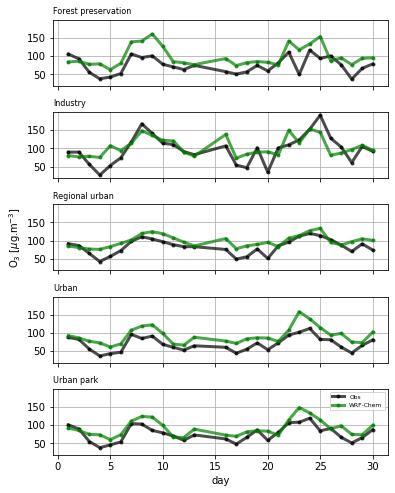

In [42]:
fig, ax = plt.subplots(len(types),
                       figsize=(6,8),
                       sharey=True,
                       sharex=True,
                       gridspec_kw={'hspace':0.4})
for i in range(len(types)):
    MDA8.loc[MDA8.type ==types[i]].groupby(['type','day'])\
    .mean().reset_index().set_index('day')\
    .plot(ax=ax[i], legend=False, grid=True, fontsize=10,
          color='kg', lw=3, marker='.', alpha=.7)
    ax[i].set_title(types[i],size=8, loc='left')
    ax[2].set_ylabel('O$_3$ [$\mu$g.m$^{-3}$]')
    if i == len(types)-1:
        ax[i].legend(['Obs','WRF-Chem'],fontsize=6)
fig.savefig('../4_Draft_Report/Dissertation/fig/MDA8_type.pdf',bbox_inches='tight', facecolor='w')

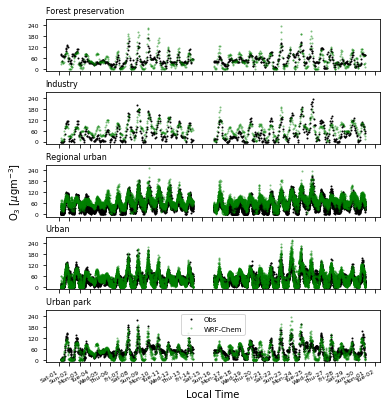

In [21]:
subplots(data.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='o3',
         ylabel='O$_3$ [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(6,7),
         n_yticks=5,
         n_xticks=1,
         filename='../4_Draft_Report/Dissertation/fig/Sep18_type',
         alpha=.5,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='type')

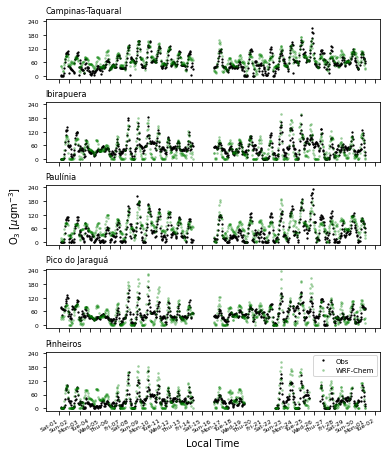

In [43]:
st_names = ['Pico do Jaraguá','Paulínia','Campinas-Taquaral','Pinheiros','Ibirapuera']
df_plot = data[data.station.isin(st_names)]

subplots(df_plot.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='o3',
         ylabel='O$_3$ [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(6,8),
         n_yticks=5,
         n_xticks=1,
         filename='../4_Draft_Report/Dissertation/fig/Sep18_station',
         alpha=.4,
         markersize=2.5,
         lw=2,
         labelsize=6, 
         by='station')

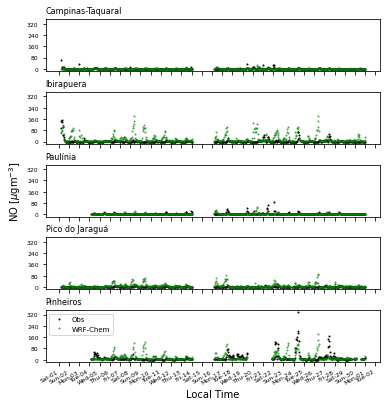

In [44]:
by = 'station'
subplots(df_plot.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='no',
         ylabel='NO [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(6,7),
         n_yticks=5,
         n_xticks=1,
         filename='../4_Draft_Report/Dissertation/fig/Sep18_'+by,
         alpha=.7,
         markersize=2,
         lw=2,
         labelsize=6, 
         by=by)

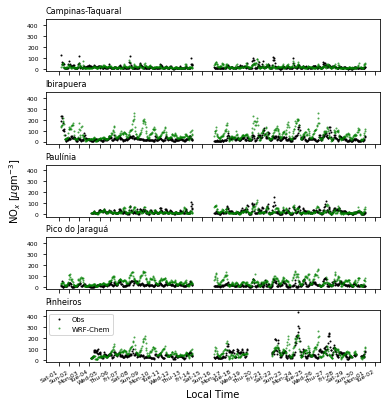

In [45]:
subplots(df_plot.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='nox',
         ylabel='NO$_x$ [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(6,7),
         n_yticks=5,
         n_xticks=1,
         filename='../4_Draft_Report/Dissertation/fig/Sep18_station',
         alpha=.7,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='station')

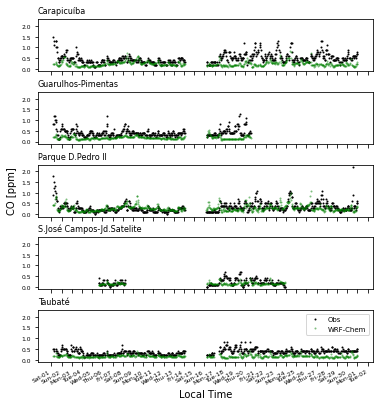

In [49]:
subplots(data.set_index('local_date').dropna(), #[data.station.isin(gr_1)]
         pol='co',
         ylabel='CO [ppm]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(6,7),
         n_yticks=5,
         n_xticks=1,
         filename='../4_Draft_Report/Dissertation/fig/Sep18_station',
         alpha=.5,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='station')

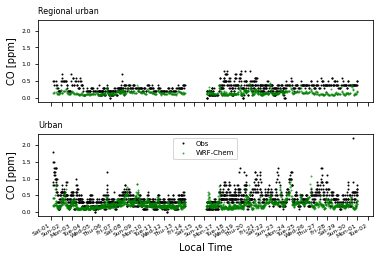

In [50]:
subplots(data.set_index('local_date').dropna(), #[data.station.isin(gr_1)]
         pol='co',
         ylabel='CO [ppm]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(6,4),
         n_yticks=5,
         n_xticks=1,
         filename='../4_Draft_Report/Dissertation/fig/Sep18_type',
         alpha=.7,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='type')

## Variation by hour of day 

In [68]:
data.set_index('local_date', inplace = True)
data

,tc_obs,rh_obs,sr,ws_obs,wd_obs,code,station,type,o3_obs,no_obs,...,nox_obs,tc_mod,rh_mod,ws_mod,wd_mod,o3_mod,no_mod,no2_mod,co_mod,nox_mod
local_date,,,,,,,,,,,,,,,,,,,,,
2018-09-01 00:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,NaN,NaN,...,NaN,23.298310,44.076140,2.693815,7.026842,27.682203,2.239252,49.752037,0.219564,51.991289
2018-09-01 01:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,0.0,NaN,...,NaN,22.410126,48.023920,2.216470,6.119945,21.225119,3.053056,51.420452,0.214394,54.473508
2018-09-01 02:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,0.0,NaN,...,NaN,21.407288,52.332270,1.305349,50.996380,4.005378,18.056173,67.957460,0.276220,86.013633
2018-09-01 03:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,0.0,NaN,...,NaN,20.983826,53.653320,1.469841,60.283295,3.622969,19.596310,67.286620,0.272637,86.882930
2018-09-01 04:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,0.0,NaN,...,NaN,21.093628,51.141346,2.060035,22.507019,9.613392,9.917302,61.067800,0.232560,70.985102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 17:00:00-03:00,NaN,NaN,NaN,NaN,NaN,236,S.Miguel Paulista,Urban,NaN,NaN,...,NaN,24.731720,71.307120,2.965886,324.791470,91.993940,0.655603,14.652246,0.129748,15.307849
2018-09-30 18:00:00-03:00,NaN,NaN,NaN,NaN,NaN,236,S.Miguel Paulista,Urban,NaN,NaN,...,NaN,24.031890,76.539470,1.747602,352.576700,64.590930,0.892898,34.685493,0.194431,35.578391
2018-09-30 19:00:00-03:00,NaN,NaN,NaN,NaN,NaN,236,S.Miguel Paulista,Urban,NaN,NaN,...,NaN,23.889557,76.684690,2.237295,307.205050,39.213230,1.555924,52.712790,0.233562,54.268714


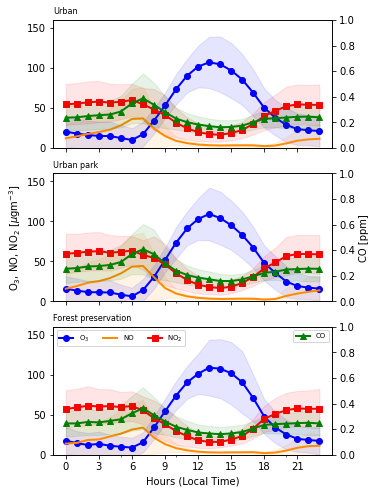

In [145]:
fig, ax = plt.subplots(3, sharex=True, figsize=(5,8))
types = ['Urban', 'Urban park','Forest preservation']
alpha = .1
lw = 2
for i, t in enumerate(types):
    df = data[data.type == t][['o3_mod', 'no_mod', 'no2_mod', 'co_mod']]
    mean = df.groupby(df.index.hour).mean()
    sd = df.groupby(df.index.hour).std()
    
    mean.plot(y=['o3_mod', 'no_mod', 'no2_mod'], 
              style=['-o','-','-s'], color=['b', 'darkorange','r'], lw=lw,
              ax=ax[i], legend=False)
    ax[i].fill_between(mean.index, mean.o3_mod+sd.o3_mod,mean.o3_mod-sd.o3_mod,
                       color='b',alpha=alpha )
    ax[i].fill_between(mean.index, mean.no_mod+sd.no_mod,mean.no_mod-sd.no_mod,
                       color='darkorange',alpha=alpha)
    ax[i].fill_between(mean.index, mean.no2_mod+sd.no2_mod,mean.no2_mod-sd.no2_mod,
                       color='r',alpha=alpha)
    ax[i].set_ylim(0,160)
    ax[i].set_title(t, loc='left', fontsize=8)
    ax[i].set_xlabel('Hours (Local Time)')
    plt.xticks(np.arange(0,24,3))
    
    
    ax2 = ax[i].twinx()
    mean.plot(y='co_mod', ax=ax2, style='-^g', lw=lw, legend=False)
    ax2.set_ylim(0,1)
    ax2.fill_between(mean.index, mean.co_mod+sd.co_mod,mean.co_mod-sd.co_mod,
                       color='g',alpha=alpha )
    if i ==1:
        ax[i].set_ylabel('O$_3$, NO, NO$_2$ [$\mu$gm$^{-3}$]')
        ax2.set_ylabel('CO [ppm]')
    if i == 2:
        ax[i].legend(['O$_3$','NO','NO$_2$'], ncol=3, fontsize=7, loc=2)
        ax2.legend(['CO'], fontsize=7, loc=1)
fig.savefig('../4_Draft_Report/Dissertation/fig/Variation_pol_day.pdf', bbox_inches='tight', facecolor='w')

In [161]:
mean={}

for i, t in enumerate(types):
    df = {}
    df[t] = data[data.type == t][['o3_mod', 'no_mod', 'no2_mod', 'co_mod']]
    mean[t] = df[t].groupby(df[t].index.hour).mean()
    
pd.concat([mean['Urban'],mean['Urban park'], mean['Forest preservation']], axis=1, keys=types)

Urban                                  Urban park             \
                o3_mod     no_mod    no2_mod    co_mod      o3_mod     no_mod   
local_date                                                                      
0            20.163927  11.981732  54.283721  0.235654   15.728826  15.763071   
1            17.800709  14.356155  55.444126  0.238778   13.445269  19.062503   
2            16.067377  17.300187  56.814743  0.248279   11.519358  23.216113   
3            14.809622  19.771513  57.904053  0.255122   11.279804  25.208678   
4            14.745022  22.640797  56.473262  0.260243   11.024478  29.020839   
5            12.177907  28.164640  57.701579  0.283950    8.338403  34.976041   
6             9.821216  36.077895  59.718684  0.347565    6.185071  43.293627   
7            17.039975  36.886879  54.476383  0.386873   14.103658  44.244249   
8            33.974808  24.095064  47.859852  0.336245   30.623950  30.261843   
9            53.057909  14.662321  40.963465  0.278797   51.811639  16.576234   
10           73.337590   8.767766  31.460018  0.228405   73.312802   9.777381   
11           90.211530   5.816502  24.364300  0.200183   91.127555   6.247728   
12          101.668892   4.081912  19.548990  0.182248  102.932548   4.312152   
13          106.944852   3.259707  17.133646  0.169720  109.230128   3.362709   
14          104.489946   2.902789  16.243075  0.160498  104.117046   2.953237   
15           96.696954   3.082216  18.530977  0.163352   95.132988   3.122021   
16           85.369242   3.153233  22.239865  0.173520   82.955340   3.311854   
17           68.794995   3.082315  29.912656  0.200638   67.141026   3.166179   
18           49.847587   2.107437  39.793291  0.226815   47.726498   2.199355   
19           37.735504   2.858318  46.203746  0.231066   35.532372   2.830245   
20           28.581136   5.555894  52.058626  0.236991   24.753869   6.766595   
21           23.474629   8.909624  54.361059  0.242679   19.084414   9.725112   
22           21.936545  10.560614  53.933018  0.243811   17.124599  11.901439   
23           20.999570  11.263232  53.578788  0.238351   15.829544  13.745068   

                                Forest preservation                        \
              no2_mod    co_mod              o3_mod     no_mod    no2_mod   
local_date                                                                  
0           59.539179  0.254149           17.612890  14.002648  57.180006   
1           60.540873  0.260106           14.664736  14.911203  59.274166   
2           62.229792  0.272212           12.206328  18.533697  61.399165   
3           62.719284  0.275532           13.766677  19.214984  60.406298   
4           60.734366  0.284203           11.249663  22.923208  60.904758   
5           61.901008  0.307345           10.105277  26.458622  59.699142   
6           63.500476  0.368998            9.027635  31.585759  61.039397   
7           57.912212  0.406940           15.652386  34.057143  55.453668   
8           54.305369  0.368204           34.183273  21.392927  45.963227   
9           46.181773  0.296345           54.377321  13.359779  38.128254   
10          35.006454  0.239042           74.120202   8.309373  29.678359   
11          26.640091  0.205698           90.583790   5.597682  23.401004   
12          20.815603  0.185080          101.351177   3.831473  18.103269   
13          17.974881  0.172558          109.000536   3.087967  16.112434   
14          16.475549  0.158732          107.742579   2.844732  16.127441   
15          18.323793  0.158466          101.992960   3.078709  19.068755   
16          22.866451  0.171063           90.693743   3.124290  23.530748   
17          30.587132  0.195719           70.875870   3.263833  32.794403   
18          41.310433  0.223024           47.694905   2.071789  45.134392   
19          48.595067  0.231341           34.050543   2.822896  51.109082   
20          56.504136  0.248544           25.360918   5.29